In [1]:
import pandas as pd
from datetime import datetime, date
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from pandas_profiling import ProfileReport

from lightgbm import LGBMRegressor
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV

pd.options.display.max_rows = 40
pd.options.display.max_columns = None

In [2]:
def generate_installment_dates(row):
    periodicity = row.Periodicity
    deltas_periodicity = {
        "Biweekly": relativedelta(weeks=2),
        "Weekly": relativedelta(weeks=2),
        "Monthly": relativedelta(months=1)
    }
    if periodicity not in deltas_periodicity:
        return []
    
    delta_periodicity = deltas_periodicity[periodicity]
    
    orig_date = row.OriginationDate
    terms = row.Term
    
    dates = []
    curr = orig_date
    for _ in range(terms):
        curr += delta_periodicity
        dates.append(curr.date())
    
    return dates

# Load and analyze data

## Agency product name
>  Información sobre agencia que agrupa créditos, el tipo de crédito (PDL o BGL, payday loans o business growth loans, respectivamente).

```
AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Country (Categórica): País de la operación.
```

In [3]:
df_agency = pd.read_csv("loan_agency_product_name.csv")
profile = ProfileReport(df_agency, title="Agency product name", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Funding Origination

> Información sobre a qué agencia pertenece cada crédito y la fecha de creación de cada crédito.

```
- LoanId (Entero): ID único del crédito.

- AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

- FundingID (Entero): ID de la entidad financiadora.

- OriginationDate (Datetime): Fecha de originación del crédito.

- InstallmentAmount (Decimal): Valor del préstamo (valor de la cuota correspondiente = InstallmentAmount/Term).

- Periodicity (Categórica): Periodicidad del crédito.

- LoanOperationalStatus (Categórica): Estado operacional del crédito al fin del período (diciembre 2020).

- VAT (Entero): Porcentaje asignado al IVA.

- Term (Entero): Cantidad de plazos del crédito.
```

In [4]:
df_orig = pd.read_csv("loan_funding_origination_info.csv", parse_dates=["OriginationDate"])
df_orig.rename(inplace=True, columns={"InstallmentAmount":"LoanAmount"})
df_orig["InstallmentAmount"] = df_orig.LoanAmount / df_orig.Term

profile = ProfileReport(df_orig, title="Funding Origination", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

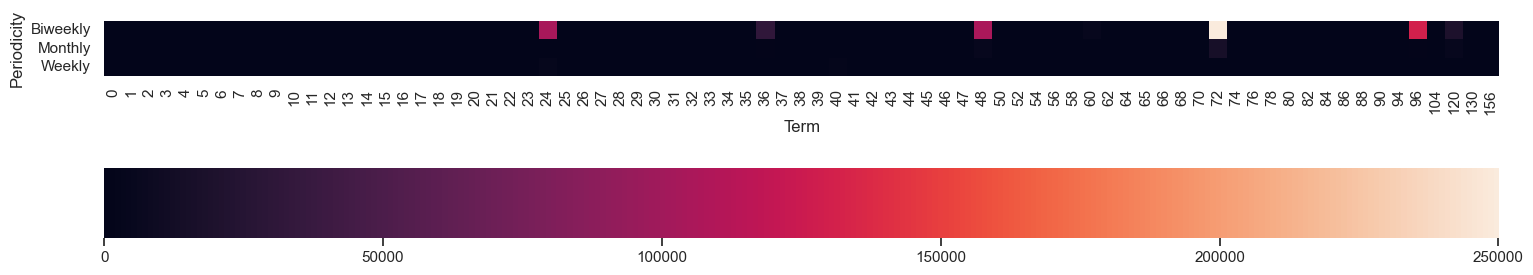

In [5]:
plt.figure(figsize=(18,8))
sns.heatmap(
    df_orig.pivot_table(index="Periodicity", columns="Term", values="LoanId", aggfunc="count", fill_value=0),
    square=True,
    cbar_kws={"orientation":"horizontal"},
)
plt.show()

## Payments
> Incluye pagos y dinámica histórica (desde 2019) de las operaciones de Hopp. La creación de créditos fue removida desde 2019 en adelante. Datos hasta junio 2020 inclusive.

```
LoanId (Entero): ID único del crédito.

PaymentId (Entero): ID único de cada pago.

PaymentSource (Categórica): Fuente de Pago (regular, contractor, alternative, additional).

PaymentType (Entero): Variable que clasifica distintos mecanismos de pago adicional.

PaymentTypeDescription (Categórica): Descripción de los mecanismos de pago adicional.

PaymentAmount (Decimal): Total pagado en el pago con PaymentId de la fila.

PaymentPrincipalAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de principal.

PaymentInterestAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de interés.

PaymentVATAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de IVA.

PaymentDueDate (Datetime): Fecha de aplicación del pago procesado (no disponible para todas las PaymentSources).

PaymentTransferDate (Datetime): Fecha en que Hopp recibió la transferencia bancaria del pago indicado (no disponible para todas las PaymentSources).

PaymentProcessingDate (Datetime): Fecha en que Hopp procesó el pago indicado (disponible para todas las PaymentSources).
```

In [6]:
df_payments = pd.read_csv("loan_payments_dataset.csv", parse_dates=["PaymentProcessingDate", "PaymentTransferDate", "PaymentDueDate"])

profile = ProfileReport(df_payments, title="Payments", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Difference between processing date and transfer date'}, xlabel='days', ylabel='count'>

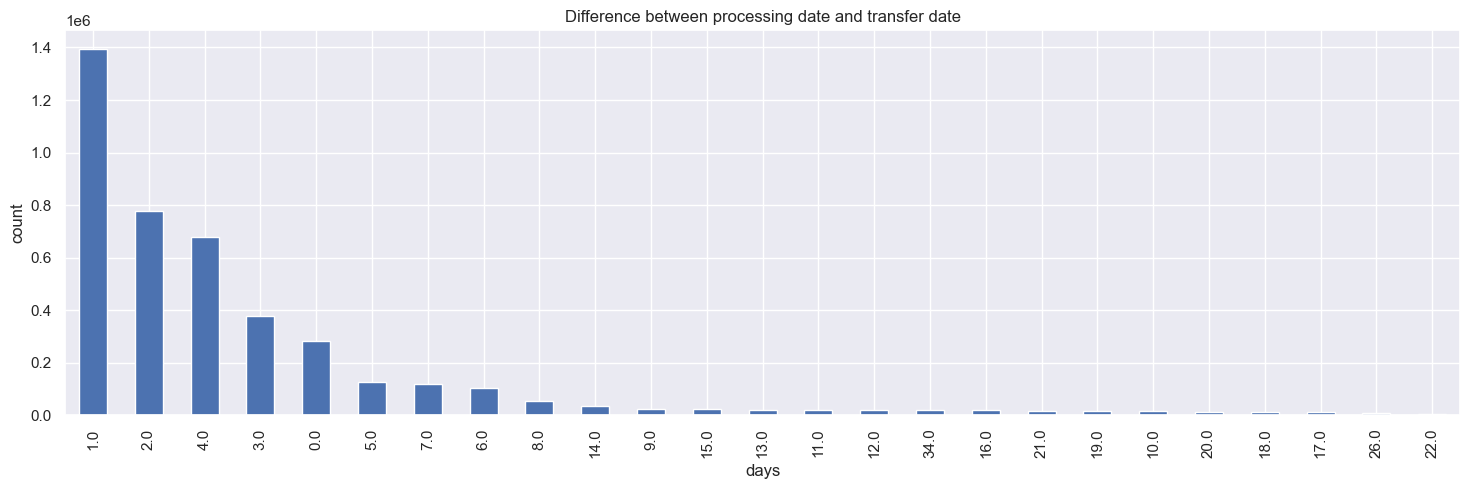

In [7]:
(df_payments.PaymentProcessingDate - df_payments.PaymentTransferDate).dt.days.value_counts().head(25).plot(
    kind="bar", title="Difference between processing date and transfer date",
    figsize=(18,5), xlabel="days", ylabel="count"
)

<AxesSubplot:title={'center':'Difference between payment due date and payment transfer date'}, xlabel='days', ylabel='count'>

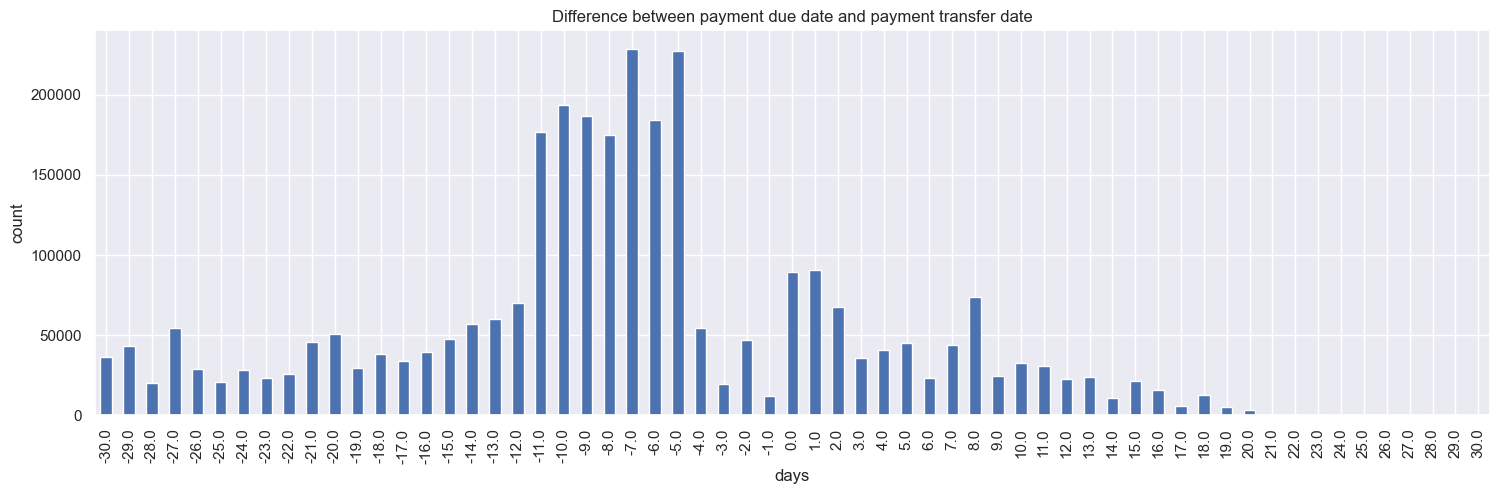

In [8]:
x = (df_payments[df_payments.PaymentDueDate.notna()].PaymentDueDate - df_payments[df_payments.PaymentDueDate.notna()].PaymentTransferDate).dt.days
x = x[x.between(-30, 30)].value_counts().sort_index()
x.plot(
    kind="bar", title="Difference between payment due date and payment transfer date", figsize=(18,5), xlabel="days", ylabel="count"
)

In [9]:
df_payments["DiffProcessingDateDueDate"] = (df_payments["PaymentProcessingDate"] - df_payments["PaymentDueDate"]).dt.days

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<AxesSubplot:xlabel='DiffProcessingDateDueDate', ylabel='Density'>

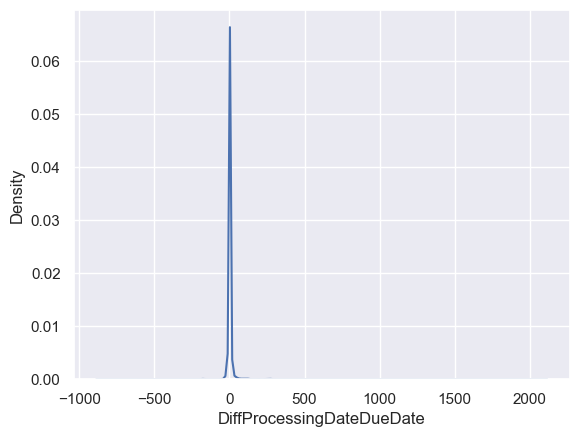

In [10]:
mean_diffdates = df_payments[df_payments.PaymentSource == "Regular"].sort_values("PaymentProcessingDate").groupby("LoanId").DiffProcessingDateDueDate.apply(np.diff).apply(np.mean)
sns.kdeplot(mean_diffdates)

In [11]:
mean_diffdates[mean_diffdates.between(-1,1)]

LoanId
3600      -0.105263
3846      -0.472222
3880      -0.472222
3881      -0.472222
3900      -0.472222
             ...   
9417747    0.000000
9417748   -0.565217
9417749    0.000000
9417751   -0.210526
9417757    0.060606
Name: DiffProcessingDateDueDate, Length: 105101, dtype: float64

In [12]:
df_payments[df_payments.PaymentPrincipal > 0].LoanId.value_counts().head()

9138385    84
9126402    84
9405682    71
9379384    71
9344259    71
Name: LoanId, dtype: int64

<AxesSubplot:>

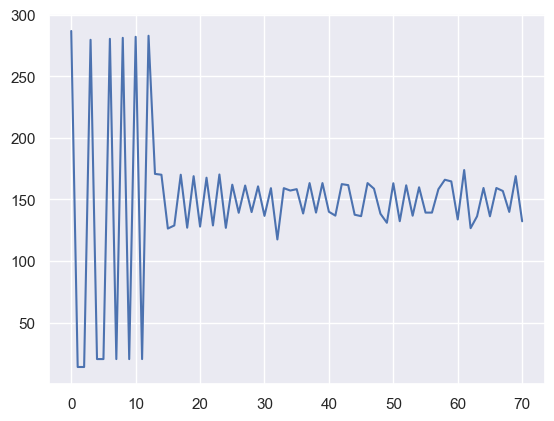

In [13]:
df_payments[(df_payments.PaymentPrincipal > 0) & (df_payments.LoanId == 9344259)].sort_values("PaymentProcessingDate").PaymentPrincipal.reset_index(drop=True).plot()

In [28]:
from sklearn.linear_model import LinearRegression, Ridge

def fit_lr(arr):
    lr = Ridge()
    x = np.arange(0, len(arr)).reshape(-1, 1)
    y = arr
    lr.fit(x, y)
    return (lr.intercept_, *list(lr.coef_))

coefs = pd.DataFrame(
    df_payments[
        (df_payments.PaymentPrincipal > 0)
    ].sort_values(
        ["LoanId", "PaymentProcessingDate"]
    ).groupby("LoanId").PaymentPrincipal.apply(fit_lr)
).rename(columns={"PaymentPrincipal": "RidgeCoefs"})

coefs = pd.DataFrame.from_records(
    coefs.RidgeCoefs.reset_index(drop=True),
    index=coefs.index,
    columns=["ridge_intercept", *[f"ridge_coef_{i}" for i in range(len(coefs.iloc[0].RidgeCoefs) - 1)]]
)

In [29]:
coefs.head()

ridge_intercept  ridge_coef_0
LoanId                               
303                0.53           0.0
1326              20.00           0.0
1763             500.00           0.0
1829             399.00           0.0
1884             465.00           0.0

In [30]:
# df_payments[(df_payments.PaymentPrincipal > 0) & (df_payments.LoanId == 9417754)]#.PaymentPrincipal.plot()

In [31]:
# df_orig[df_orig.LoanId == 9417754]

## Indexed dataset
> Información de tipo de indexación de cada crédito en el portafolio.

```
LoanId (Entero): ID único del crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Type (Categórica): Variable que indica si el crédito está indexado (Base, D-Indexed).

D-IndexedTo (Categórica): Variable que indica a quién indexa el crédito (Hopp, Zoltan, Ringu, Freeman).
```

In [32]:
df_dindex = pd.read_csv("loan_dindexedto_dataset.csv")

profile = ProfileReport(df_dindex, title="Indexed to", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Predictions sample
> Template con los préstamos y fechas a predecir.

In [33]:
predictions_sample = pd.read_csv("loan_payments_dataset_scoring.csv", names=["PaymentCode", "PaymentPrincipal"], dtype={
    "PaymentCode": str,
    "PaymentPrincipal": float
})

predictions_sample = predictions_sample.join(predictions_sample.PaymentCode.astype(str).str.extract(r'^(?P<PaymentSource>\d{2})(?P<Date>\d{6})(?P<LoanId>.*)'))

predictions_sample.LoanId = predictions_sample.LoanId.astype(int)
predictions_sample.PaymentSource = predictions_sample.PaymentSource.astype(int)
# predictions_sample.PaymentTypeId = predictions_sample.PaymentTypeId.astype(int)

predictions_sample.Date = pd.to_datetime(predictions_sample.Date, format="%y%m%d").dt.date

predictions_sample["PaymentType"] = predictions_sample.PaymentSource.apply(lambda x: x if x not in (0,1,2) else None)

predictions_sample.PaymentSource = predictions_sample.PaymentSource.map({
    0: "Regular",
    1: "Alternative",
    2: "Contractor"
}).fillna("Alternative")

In [34]:
predictions_sample.head()

PaymentCode  PaymentPrincipal PaymentSource        Date   LoanId  \
0  022102049402357               NaN    Contractor  2021-02-04  9402357   
1   00201030668519               NaN       Regular  2020-10-30   668519   
2  002011249339435               NaN       Regular  2020-11-24  9339435   
3  002104209148631               NaN       Regular  2021-04-20  9148631   
4   00210607131505               NaN       Regular  2021-06-07   131505   

   PaymentType  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [35]:
orig_loanids = set(df_orig.LoanId.unique())
predictions_loanids = set(predictions_sample.LoanId.unique())
print(f"All predictions in payments? {(orig_loanids & predictions_loanids) == predictions_loanids}. Diff: {len(predictions_loanids - orig_loanids)}")

All predictions in payments? False. Diff: 5


In [36]:
predictions_sample[~predictions_sample.LoanId.isin(df_orig.LoanId)]

PaymentCode  PaymentPrincipal PaymentSource        Date  LoanId  \
7928     002110295405               NaN       Regular  2021-10-29    5405   
50127    002112285406               NaN       Regular  2021-12-28    5406   
944338   002110225404               NaN       Regular  2021-10-22    5404   
1109375  002112305409               NaN       Regular  2021-12-30    5409   
1116352  002107205403               NaN       Regular  2021-07-20    5403   
1220610  002107235403               NaN       Regular  2021-07-23    5403   

         PaymentType  
7928             NaN  
50127            NaN  
944338           NaN  
1109375          NaN  
1116352          NaN  
1220610          NaN

In [37]:
cheats = {
"002107235403":1474,
"002107205403":1474,
"002110225404":591,
"002110295405":488,
"002112285406":1247,
"002112305409":1253
}

In [38]:
loan_ids_to_predict = predictions_sample.LoanId.unique()

<AxesSubplot:>

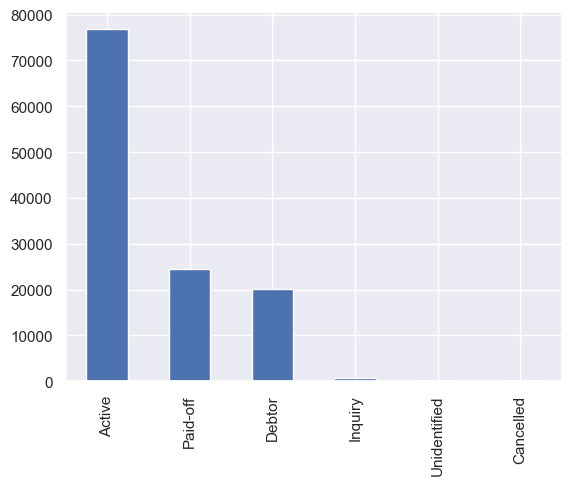

In [39]:
df_orig[df_orig.LoanId.isin(loan_ids_to_predict)].LoanOperationalStatus.value_counts().plot(kind="bar")

In [40]:
predictions_sample.LoanId.value_counts()

653139     64
9361293    64
9275791    59
9343898    59
9359087    59
           ..
9143458     1
9145866     1
519749      1
9279168     1
9153809     1
Name: LoanId, Length: 122351, dtype: int64

# Cross reference payments and origin

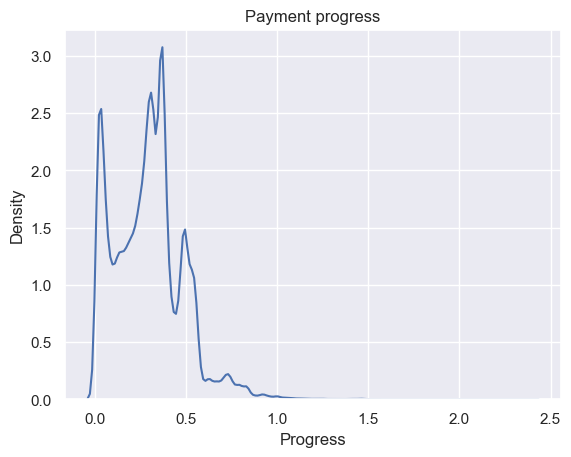

In [41]:
df = df_orig.merge(
    df_payments.LoanId.value_counts().rename("PaymentsRegistered"),
    left_on="LoanId",
    right_index=True
)
df["Progress"] = df.PaymentsRegistered / df.Term
sns.kdeplot(df[np.isfinite(df.Progress)].Progress)
plt.title("Payment progress")
plt.show()

# Do we need to predict for wanky loans?

In [42]:
predictions_sample.LoanId.isin(
    df_orig[df_orig.Term == 0].LoanId
).nunique()

2

# Orient data

In [43]:
df = pd.merge(df_payments, df_orig, left_on="LoanId", right_on="LoanId", how="left").sort_values(["PaymentProcessingDate", "LoanId", "PaymentId"])

df = df.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

nzpayments = df[df.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
    columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
)
df = pd.merge_asof(df, nzpayments, left_on="PaymentProcessingDate", right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False)

ppa = df_payments[(df_payments.PaymentPrincipal > 0)].groupby("LoanId").PaymentPrincipal.agg(["mean", "median"]).rename(
    columns={"mean":"PaymentPrincipalMean", "median":"PaymentPrincipalMedian"}
)
df = df.merge(ppa, on="LoanId", how="left")

df = df.merge(coefs, on="LoanId", how="left")

df["DaysSincePreviousNonZeroPayment"] = (df.PaymentProcessingDate - df.LastNonZeroPaymentProcessingDate).dt.days

df["WasLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 15
df["WasReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 30
df["WasReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 90
df["WasReallyReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 180

df["WasEverLate"] = df.groupby("LoanId").WasLate.cumsum()# > 0
df["WasEverReallyLate"] = df.groupby("LoanId").WasReallyLate.cumsum()# > 0
df["WasEverReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyLate.cumsum()# > 0
df["WasEverReallyReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyReallyLate.cumsum()# > 0

df["AccumulatedPrincipals"] = df.groupby("LoanId").PaymentPrincipal.cumsum()
df["PrincipalPaidOff"] = df.AccumulatedPrincipals >= df.LoanAmount
df["PrincipalPaidOffProportion"] = df.AccumulatedPrincipals / df.LoanAmount

In [44]:
df["InstallmentProportion"] = df.PaymentPrincipal / df.InstallmentAmount

df = pd.merge_asof(df, df[["LoanId", "PaymentProcessingDate", "InstallmentProportion"]].rename(columns={"InstallmentProportion":"LastInstallmentProportion"}),
    left_on="PaymentProcessingDate", right_on="PaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False
)

In [45]:
categories = ["PaymentSource", "PaymentType", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo"]
for category in categories:
    df[category] = df[category].astype("category")

In [46]:
# podria usar origination date

In [47]:
train_columns = [
    'PaymentSource',
    'PaymentType',
    'AgencyId',
    'FundingID',
    #'LoanAmount',
    'Periodicity',
    'VAT',
    'Term',
    'InstallmentAmount',
    'ProductName',
    'Type',
    'D-IndexedTo',
    'PaymentPrincipalMean',
    'PaymentPrincipalMedian',
    #'LastNonZeroPaymentPrincipal',
    #'DaysSincePreviousNonZeroPayment',
    'WasEverLate',
    'WasEverReallyLate',
    'WasEverReallyReallyLate',
    'WasEverReallyReallyReallyLate',
    #'LastInstallmentProportion',
    #'AccumulatedPrincipals',
    #"PrincipalPaidOffProportion",
    #'PrincipalPaidOff'
    "ridge_intercept",
    "ridge_coef_0"
]

In [48]:
train_df = df[(df.PaymentAmount >= 0) & (df.LoanAmount > 0)]

In [49]:
loans = train_df.LoanId.value_counts()
loans = loans[loans > 0]
len(loans)

190034

In [50]:
train_df = train_df[train_df.LoanId.isin(loans.index)]

In [51]:
train_df = train_df.sort_values(["LoanId", "PaymentProcessingDate"])
groups = LabelEncoder().fit_transform(train_df.LoanId)

In [52]:
y = train_df.PaymentPrincipal # InstallmentProportion
X = train_df[train_columns]

In [53]:
#cv_args = {"test_size": 1, "train_size": 4}
#cv = GroupTimeSeriesSplit(**cv_args)
#cv_splits = [_ for _ in cv.split(X, y, groups=groups)]
#reg = DummyRegressor()
#cross_val_score(reg, X, y, groups=groups, cv=cv).mean()

In [54]:
cv_args = {"test_size": 100, "n_splits": 10}
cv = GroupTimeSeriesSplit(**cv_args)
_ = [_ for _ in cv.split(X, y, groups=groups)]
cv.get_n_splits()

10

In [55]:
from xgboost import XGBRegressor

/home/nox/repos/venv/lib64/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [56]:
reg = LGBMRegressor()
# reg = XGBRegressor()
#cross_val_score(reg, X, y, groups=groups, cv=cv).mean()
gscv = GridSearchCV(
    reg,
    param_grid={
        "silent":[False],
        "n_estimators":[2,5,10,25,50,75,100],
        "learning_rate":[0.01, 0.1, 0.25, 0.5, 1.0],
        "metric":["mae"],
        #"enable_categorical":[True]
        "force_row_wise":[True]
    },
    n_jobs=1,
    refit=True,
    cv=cv,
    verbose=1,
    scoring="neg_mean_absolute_error"
)
fit_reg = gscv.fit(X, y, groups=groups)
gscv.best_score_

Fitting 10 folds for each of 35 candidates, totalling 350 fits
[LightGBM] [Info] Total Bins 1931
[LightGBM] [Info] Number of data points in the train set: 4298093, number of used features: 19
[LightGBM] [Info] Start training from score 385.632552
[LightGBM] [Info] Total Bins 1929
[LightGBM] [Info] Number of data points in the train set: 4298109, number of used features: 19
[LightGBM] [Info] Start training from score 385.631117
[LightGBM] [Info] Total Bins 1934
[LightGBM] [Info] Number of data points in the train set: 4298130, number of used features: 19
[LightGBM] [Info] Start training from score 385.629683
[LightGBM] [Info] Total Bins 1922
[LightGBM] [Info] Number of data points in the train set: 4298148, number of used features: 19
[LightGBM] [Info] Start training from score 385.629501
[LightGBM] [Info] Total Bins 1921
[LightGBM] [Info] Number of data points in the train set: 4298181, number of used features: 19
[LightGBM] [Info] Start training from score 385.627472
[LightGBM] [Info]

-114.57754629704058

In [57]:
#import sklearn
#sklearn.metrics.get_scorer_names()

In [58]:
gscv.best_params_

{'force_row_wise': True,
 'learning_rate': 0.5,
 'metric': 'mae',
 'n_estimators': 100,
 'silent': False}

In [59]:
sorted(
    list(
        zip(
            gscv.best_estimator_.feature_name_,
            gscv.best_estimator_.feature_importances_
        )
    ),
    key=lambda x: x[1]
)

[('ProductName', 0),
 ('D-IndexedTo', 0),
 ('VAT', 2),
 ('Type', 2),
 ('WasEverReallyReallyReallyLate', 9),
 ('WasEverReallyReallyLate', 10),
 ('Periodicity', 20),
 ('Term', 47),
 ('WasEverReallyLate', 55),
 ('FundingID', 111),
 ('WasEverLate', 155),
 ('PaymentType', 179),
 ('PaymentSource', 200),
 ('ridge_coef_0', 231),
 ('ridge_intercept', 264),
 ('PaymentPrincipalMedian', 365),
 ('AgencyId', 377),
 ('PaymentPrincipalMean', 382),
 ('InstallmentAmount', 591)]

In [60]:
from sklearn.metrics import mean_absolute_error as MAE

MAE(y, gscv.predict(X)) # InstallmentProportion

159.50418016260048

In [78]:
print(len(predictions_sample))

pred = pd.merge(predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left").rename(columns={"Date": "PaymentProcessingDate"}).sort_values(["PaymentProcessingDate", "LoanId"])

print(len(pred))

pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

print(len(pred))

pred.LoanId = pred.LoanId.astype(int)
pred.PaymentProcessingDate = pd.to_datetime(pred.PaymentProcessingDate)

nzpayments = df_payments[df_payments.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
    columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
).sort_values(["LastNonZeroPaymentProcessingDate", "LoanId"])

pred = pd.merge_asof(pred, nzpayments, left_on="PaymentProcessingDate", right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False)

print(len(pred))

pred["DaysSincePreviousNonZeroPayment"] = (pred.PaymentProcessingDate - pred.LastNonZeroPaymentProcessingDate).dt.days

pred = pd.merge(
    pred,
    df[["WasEverLate", "WasEverReallyLate", "WasEverReallyReallyLate", "WasEverReallyReallyReallyLate", "LoanId"]].drop_duplicates(subset=["LoanId"], keep="last"),
    on="LoanId", how="left")

pred = pred.merge(ppa, on="LoanId", how="left")
pred = pred.merge(coefs, on="LoanId", how="left")

print(len(pred))

#pred["AccumulatedPrincipals"] = pred.groupby("LoanId").PaymentPrincipal.cumsum()
#pred["PrincipalPaidOff"] = pred.AccumulatedPrincipals >= pred.LoanAmount
#pred["PrincipalPaidOffProportion"] = pred.AccumulatedPrincipals / pred.LoanAmount

1848389
1848389
1848389
1848389
1848389


In [79]:
pred.WasEverLate = pred.WasEverLate.astype(bool)
pred.WasEverReallyLate = pred.WasEverReallyLate.astype(bool)
pred.WasEverReallyReallyLate = pred.WasEverReallyReallyLate.astype(bool)
pred.WasEverReallyReallyReallyLate = pred.WasEverReallyReallyReallyLate.astype(bool)

In [80]:
categories = ["PaymentSource", "PaymentType", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo"]
for category in categories:
    pred[category] = pred[category].astype("category")

In [81]:
pred["Prediction"] = gscv.predict(pred[train_columns])# * pred[train_columns].InstallmentAmount

In [82]:
for k, v in cheats.items():
    pred.loc[pred.PaymentCode == k, "Prediction"] = v

In [83]:
pred.Prediction = pred.Prediction.round(2)

In [84]:
pred.Prediction = pred.Prediction.fillna(0)

In [85]:
# df_payments.merge(df_orig[df_orig.Term == 0], on="LoanId", how="left")

In [86]:
pred[["PaymentCode", "Prediction"]].to_csv("naive.csv", header=False, index=False)